# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   8008      0 --:--:-- --:--:-- --:--:--  8178


In [2]:
from workspace_utils import active_session

In [3]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Additional imports here

In [5]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_multiple_agents import Agents
import torch
import seaborn as sns
import pandas as pd

sns.set(style="darkgrid")
sns.set_palette("Set2")

%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09999999776482582


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [9]:
def ddpg(n_episodes=5, max_steps=1000, data=None):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_steps (int): maximum number of steps per episode
        data (dict): contains all variables, so you can 
                     happily continue your training where it were left
    """
    if not data:
        scores_window = deque(maxlen=100)
        scores = np.zeros(num_agents)
        scores_episode = []
        steps = []
        agents = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)
    else:
        scores_window = data["scores_window"]
        scores = data["scores"]
        scores_episode = data["scores_episode"]
        steps = data["steps"]
        agents = data["agents"]

    last_mean_score = 30
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agents.reset()
            
        scores = np.zeros(num_agents)

        for s in range(max_steps):
            actions = agents.act(states)
            env_info = env.step(actions)[brain_name]        
            next_states = env_info.vector_observations    
            rewards = env_info.rewards                     
            dones = env_info.local_done        
            
            agents.step(states, actions, rewards, next_states, dones)
 
            states = next_states
            scores += rewards
            if s % 20:
                print('\rTimestep {}\tScore: {:.2f}\tmin: {:.2f}\tmax: {:.2f}'
                      .format(s, np.mean(scores), np.min(scores), np.max(scores)), end="") 
            if np.any(dones):
                break 
        # If run for multiple agents, we have to take average score
        score = np.mean(scores)
        scores_window.append(score)      
        scores_episode.append(score)
        steps.append(s)

        if i_episode % 10 == 0:
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="\n")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, round(np.mean(scores_window), 2)))
        
        if len(scores_window) == 100:
            # Constantly update if mean score has been improved
            mean_score = np.mean(scores_window)
            if mean_score > last_mean_score:
                torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
                last_mean_score = mean_score

        # Finish solving after some leeway of 3 score at least
        if np.mean(scores_window)>=33.0:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, round(np.mean(scores_window), 2)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return {"scores_episode": scores_episode,
            "scores_window": scores_window,
            "scores" : scores,
            "agents": agents,
            "steps" : steps}

Episode 10	Score: 21.1209	min: 13.74	max: 26.78
Episode 20	Score: 36.8178	min: 34.00	max: 39.36
Episode 30	Score: 33.9390	min: 27.69	max: 37.69
Episode 40	Score: 34.5956	min: 31.53	max: 37.41
Episode 50	Score: 36.1410	min: 32.97	max: 39.12
Episode 60	Score: 37.3229	min: 34.46	max: 39.44
Episode 70	Score: 31.3027	min: 19.82	max: 35.42
Episode 80	Score: 33.6460	min: 24.33	max: 37.92
Episode 90	Score: 34.7976	min: 30.10	max: 39.40
Episode 100	Score: 34.639	min: 31.66	max: 37.60
Episode 100	Average Score: 31.91
Timestep 999	Score: 36.26	min: 34.22	max: 38.65
Environment solved in 104 episodes!	Average Score: 33.28


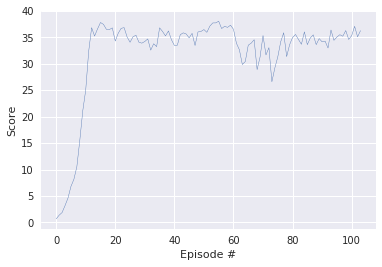

In [10]:
with active_session():
    _data = ddpg(n_episodes=500, max_steps=10000)
    scores = _data["scores_episode"]
    sns.set(style="darkgrid")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores,linewidth=0.4)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [11]:
from scipy.ndimage import gaussian_filter1d

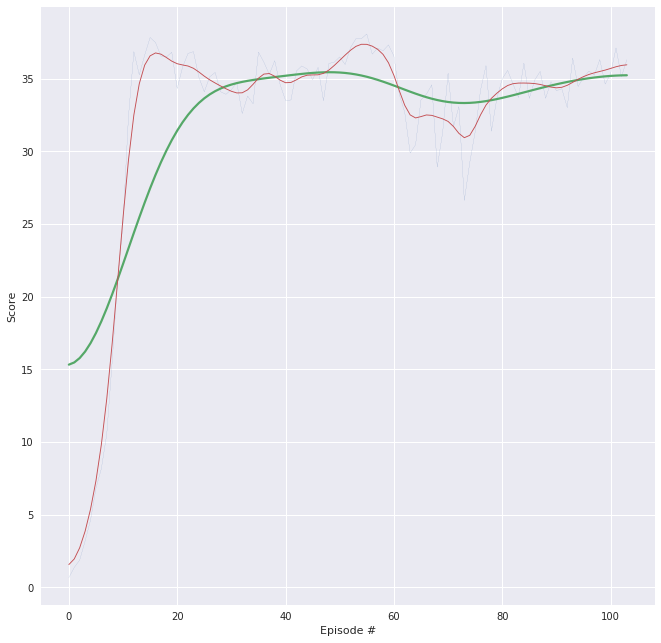

In [12]:
s = scores[:-4]
ysmoothed2 = gaussian_filter1d(scores, sigma=2)
ysmoothed3 = gaussian_filter1d(scores, sigma=10)

fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, linewidth=0.1)
plt.plot(np.arange(len(scores)), ysmoothed3, linewidth=2.2)
plt.plot(np.arange(len(scores)), ysmoothed2, linewidth=0.9)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [13]:
env.close()